# Visualizing the stray field with the "Airbox" method

In [1]:
import numpy as np
from finmag.util.meshes import from_csg, plot_mesh_with_paraview
from finmag.util.helpers import probe, scalar_valued_dg_function
from finmag import sim_with
import textwrap
import dolfin as df
df.parameters["allow_extrapolation"] = True  # need this to avoid error further below

[2014-09-12 14:55:27] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2014-09-12 14:55:27] DEBUG: Building modules in 'native'...
[2014-09-12 14:55:28] DEBUG: FinMag          5444:396c6b44360b5877869f75bc1dc5bd243689ad6a
[2014-09-12 14:55:28] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-09-12 14:55:28] DEBUG: Numpy           1.8.1                Scipy           0.14.0              
[2014-09-12 14:55:28] DEBUG: IPython         2.1.0                Python          2.7.6               
[2014-09-12 14:55:28] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2014-09-12 14:55:28] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2014-09-12 14:55:28] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


First we create a mesh consisting of a spherical (ferromagnetic) nanoparticle surrounded by a cubic mesh which represents the "air". The latter is needed to compute the stray field of the sphere because currently we can only probe the demag field at mesh nodes, not at arbitrary positions outside the mesh.


Let's start by defining some parameters for the geometry and mesh discretisation.

In [2]:
d = 50  # diameter of the sphere
l = 70  # edge length of the cube
maxh = 5.0  # mesh discretisation

Next we create the mesh by describing the mesh geometry using Netgen's CSG formalism. Note that we leave a small gap between the sphere itself and the outside box representing the air.

In [11]:
mesh_descr = textwrap.dedent("""\
    algebraic3d
    solid ball = sphere ( 0, 0, 0; {r} ) -maxh = {maxh};
    solid shell = sphere ( 0, 0, 0; {r_shell} ) -maxh = {maxh};
    solid box = orthobrick ( {sneg}, {sneg}, {sneg}; {s}, {s}, {s} ) -maxh = {maxh};
    solid air = box and not shell;
    tlo ball;
    tlo air -transparent;
    """).format(r=0.5*d, r_shell=0.55*d, sneg=-0.5*l, s=0.5*l, maxh=maxh)

mesh = from_csg(mesh_descr, filename='meshes/sphere_plus_airbox__d_{:.1f}__l_{:.1f}__maxh_{:.1f}'.format(d, l, maxh))

[2014-09-12 14:58:34] DEBUG: The mesh '/home/mb4e10/finmag/doc/ipython_notebooks_src/meshes/sphere_plus_airbox__d_50.0__l_70.0__maxh_5.0.xml.gz' already exists and is automatically returned.


We would like to have a spatially varying saturation magnetisation `Ms`. It should have the value of Permalloy (ca. 860 kA/m) inside the sphere and ideally the value of zero in the "air" region. Unfortunately, Ms=0 is not supported at the moment (presumably because we are dividing by Ms at some point), so we set it to a very small value which is effectively zero.

Currently we do the distinction by defining a spatially varying function which we feed to the Simulation object. Very soon we will be able to say something like this instead:

   ```
   sim.set_field('Ms', 8.6e5, region='sphere')
   sim.set_field('Ms', 1., region='air')
   ```

In [12]:
def Ms_fun(pt):
    if np.linalg.norm(pt) <= d * 0.51:
        return 8.6e5
    else:
        return 1.

Ms = scalar_valued_dg_function(Ms_fun, mesh)

In [13]:
sim = sim_with(mesh, Ms, m_init=[1, 0, 0], A=13e-12, unit_length=1e-9, name='sphere_with_airbox')

[2014-09-12 14:58:37] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/sphere_with_airbox.log' (any old content will be overwritten).
[2014-09-12 14:58:37] DEBUG: Creating DataWriter for file 'sphere_with_airbox.ndt'
[2014-09-12 14:58:37] INFO: Creating Sim object 'sphere_with_airbox' (rank=0/1).
[2014-09-12 14:58:37] INFO: <Mesh of topological dimension 3 (tetrahedra) with 2584 vertices and 8968 cells, ordered>
[2014-09-12 14:58:37] DEBUG: Creating LLG object.
[2014-09-12 14:58:37] DEBUG: Creating Exchange object with method box-matrix-petsc,  in Jacobian.
[2014-09-12 14:58:37] DEBUG: Adding interaction Exchange to simulation.
[2014-09-12 14:58:38] DEBUG: Creating Demag object with solver 'FK'.
[2014-09-12 14:58:38] DEBUG: Demag parameters now: {'phi_1': {'absolute_tolerance': 1e-06, 'relative_tolerance': 1e-06, 'maximum_iterations': 10000}, 'phi_2': {'absolute_tolerance': 1e-06, 'relative_tolerance': 1e-06, 'maximum_iterations': 1000

## Marking the mesh regions

Since we'd like to compute and plot the field outside the particle only, we need to tell the simulation about the two different mesh regions. We do this by defining a function which takes a point as input argument and returns either "sphere" or "air" depending on the region which it belongs to. Note that we can use any identifier for the two regions (we could also have used the numbers 0 and 1 or True and False) so long as they are unique.

In [14]:
def fun_region(pt):
    if np.linalg.norm(pt) <= 0.51 * d:
        return "sphere"
    else:
        return "air"

In [15]:
sim.mark_regions(fun_region)

## Plotting the stray field of the sphere

Now it is very simple to plot the stray field of the sphere. We simply tell the `render_scene()` method that we'd like to plot the demag field in the 'air' region only. The argument `representation='Outline'` tells Paraview not to render the mesh (otherwise the field would not be visible).

[2014-09-12 14:58:45] DEBUG: Saved field at t=0.0 to file '/tmp/tmpBQbAHE/paraview_scene_sphere_with_airbox.pvd' (snapshot #0; saving took 0.0269 seconds).


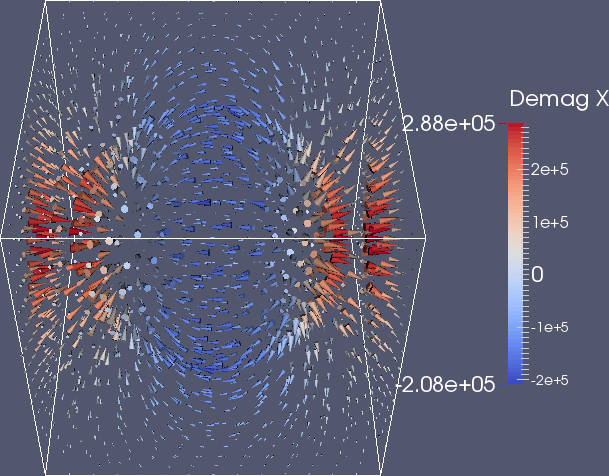

In [16]:
sim.render_scene(field_name='Demag', region='air', representation='Outline', use_display=0)

For confirmation, we can also plot the demag field inside the sphere only. We expect it to point in the negative x-direction, which it does.

[2014-09-12 14:58:49] DEBUG: Saved field at t=0.0 to file '/tmp/tmp6nataF/paraview_scene_sphere_with_airbox.pvd' (snapshot #0; saving took 0.0126 seconds).


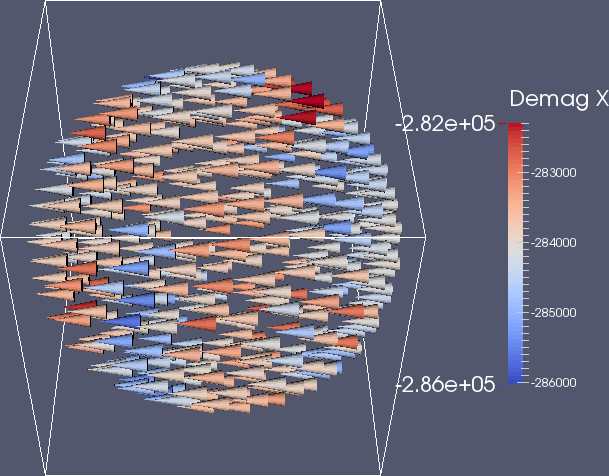

In [17]:
sim.render_scene(field_name='Demag', region='sphere', representation='Outline', use_display=0)

last reviewed: 10 Jun 2014 (MA)